In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import feature_extractor as fe
import data_cleaner as dc
# import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
import time
import seaborn as sns
import pandas as pd
import numpy as np
import sys

2023-12-14 18:55:00.924270: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
GT = "target_label"

In [4]:
# cache_path = "/home/ryan.zurrin001/binlink/sample_dataset.pkl"
cache_path = "/home/ryan.zurrin001/binlink/cs438_features_imgs.pkl"

In [5]:
# Load the DataFrame
df_features = pd.read_pickle(cache_path)

In [6]:
cleaner = dc.DataCleaner(df_features)

In [7]:
combined_img_masks, cleaned_df = cleaner.clean_data(return_img_mask_data=True, balance_classes=True, scale=True)

Cleaning data...
drop unnecessary columns
handle missing values
process ages
label encode
map labels
handle missing values
add correctness column
balance classes
create binary masks


Processing Data:   0%|          | 0/33064 [00:00<?, ?it/s]

expand and extend columns


Expanding Columns:   0%|          | 0/2 [00:00<?, ?it/s]

Extending Columns:   0%|          | 0/3 [00:00<?, ?it/s]

process and flatten columns
handle missing values
enforce numeric data types
scale data


In [8]:
len(cleaned_df)

33064

In [11]:
cleaned_df.drop(columns=['label', 'score'], inplace=True)

In [12]:
cleaned_df.columns

Index(['ImageLaterality', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
       'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
       'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
       'DetectorTemperature', 'DetectorType', 'Rows', 'Columns',
       'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
       'resized_coords1', 'resized_coords2', 'resized_coords3',
       'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
       'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
       'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
       'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
       'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
       'histogram_percentile_75', 'flattened_image_mean',
       'flattened_image_median', 'flattened_image_std',

In [13]:
combined_images = combined_img_masks

In [14]:
# print(type(preprocessed_images), preprocessed_images.shape)
# print(type(binary_masks), binary_masks.shape)
print(type(combined_images), combined_images.shape)


<class 'numpy.ndarray'> (33064, 256, 256, 2)


In [15]:
# Assuming 'cleaned_df' is your final DataFrame after cleaning
# # Features without the image data
# X = cleaned_df.drop(['target_label'], axis=1)

# # Labels
# y = cleaned_df['target_label']

# Split data and keep track of indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    cleaned_df.drop([GT], axis=1), cleaned_df[GT], range(len(cleaned_df)), 
    test_size=0.2, random_state=42
)

# Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [16]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (26451, 53)
X_test shape: (6613, 53)
y_train shape: (26451,)
y_test shape: (6613,)


In [17]:
# Assuming you have combined_images and X_train_scaled prepared

# For combined image data
image_input_shape = combined_images.shape[1:]  # This excludes the first dimension (number of samples)

# For scalar features
scalar_input_shape = (X_train.shape[1],)  # This gets the number of features

# Printing shapes for confirmation
print("Image Input Shape:", image_input_shape)
print("Scalar Input Shape:", scalar_input_shape)


Image Input Shape: (256, 256, 2)
Scalar Input Shape: (53,)


In [18]:
from tensorflow.keras.layers import Dropout

# Image input model
image_input = Input(shape=(256, 256, 2))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)  # Adding dropout
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)  # Adding dropout
x = Flatten()(x)

2023-12-14 14:06:39.505111: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-12-14 14:06:39.646321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-14 14:06:39.646369: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-12-14 14:06:39.703265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-12-14 14:06:39.703316: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-12-14 14:06:39.721416: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [32]:
# Scalar input model
scalar_input = Input(shape=(53,))
y = Dense(64, activation='relu')(scalar_input)
y = Dropout(0.25)(y)  # Adding dropout
y = Dense(32, activation='relu')(y)
y = Dropout(0.25)(y)  # Adding dropout

In [33]:
# Concatenate the outputs from the two models
combined = concatenate([x, y])

In [34]:
# Additional layers after concatenation
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)  # Adding dropout
z = Dense(32, activation='relu')(z)
z = Dropout(0.5)(z)  # Adding dropout

In [35]:
# Output layer
output = Dense(1, activation='sigmoid')(z)  # Use 'softmax' for multi-class

In [36]:
# Create the model
model = Model(inputs=[image_input, scalar_input], outputs=output)

In [37]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [38]:
# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 127, 127, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 127, 127, 32) 0           max_pooling2d[0][0]              
____________________________________________________________________________________________

In [39]:
# Reset y to be the label column from the cleaned dataframe
y = cleaned_df[GT].values  # Convert to numpy array if it's a pandas series


# Step 1: Verify that combined_images is a numpy array
print("Type of combined_images:", type(combined_images))
print("Shape of combined_images:", combined_images.shape)

# Assuming y is the labels as a numpy array
print("Type of y:", type(y))
print("Length of y:", len(y))

Type of combined_images: <class 'numpy.ndarray'>
Shape of combined_images: (33064, 256, 256, 2)
Type of y: <class 'numpy.ndarray'>
Length of y: 33064


In [40]:

# Split combined image data
X_train_images, X_test_images, y_train_images, y_test_images = train_test_split(
    combined_images, y, test_size=0.2, random_state=42
)

In [41]:
# Confirm the split
print("Shapes after split:")
print("X_train_images shape:", X_train_images.shape)
print("X_test_images shape:", X_test_images.shape)
print("y_train_images shape:", y_train_images.shape)
print("y_test_images shape:", y_test_images.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Shapes after split:
X_train_images shape: (26451, 256, 256, 2)
X_test_images shape: (6613, 256, 256, 2)
y_train_images shape: (26451,)
y_test_images shape: (6613,)
X_train shape: (26451, 53)
X_test shape: (6613, 53)
y_train shape: (26451,)
y_test shape: (6613,)


In [42]:
# Convert to numpy arrays and ensure float data type
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

# Replace inf/-inf with NaN and then fill NaNs
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Verify shapes and types
print("X_train_images shape:", X_train_images.shape, "Type:", type(X_train_images))
print("X_train shape:", X_train.shape, "Type:", type(X_train))
print("y_train shape:", y_train.shape, "Type:", type(y_train))

X_train_images shape: (26451, 256, 256, 2) Type: <class 'numpy.ndarray'>
X_train shape: (26451, 53) Type: <class 'numpy.ndarray'>
y_train shape: (26451,) Type: <class 'pandas.core.series.Series'>


In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [44]:
# from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights
# class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    [X_train_images, X_train], y_train,
    validation_data=([X_test_images, X_test], y_test),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20


2023-12-14 14:10:22.404210: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-12-14 14:10:23.633000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-12-14 14:10:25.193100: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-12-14 14:10:25.193125: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-12-14 14:10:25.193928: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-14 14:10:25.269405: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-12-14 14:10:26.793622: I tensorflow/stream_exec

827/827 [==============================] - 17s 13ms/step - loss: 1.7463 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 2/20
827/827 [==============================] - 10s 12ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 3/20
827/827 [==============================] - 10s 12ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 4/20
827/827 [==============================] - 10s 12ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 5/20
827/827 [==============================] - 10s 12ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 6/20
827/827 [==============================] - 10s 13ms/step - loss: 0.6945 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 7/20
827/827 [==============================] - 10s 12ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904


In [45]:
# # Train the model
# history = model.fit(
#     [X_train_images, X_train], y_train,
#     validation_data=([X_test_images, X_test], y_test),
#     batch_size=32,
#     epochs=20,
#     verbose=1
# )

# Evaluate the model
evaluation = model.evaluate([X_test_images, X_test], y_test)
print("Test loss:", evaluation[0])
print("Test accuracy:", evaluation[1])


207/207 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4904
Test loss: 0.6932225823402405
Test accuracy: 0.49039769172668457


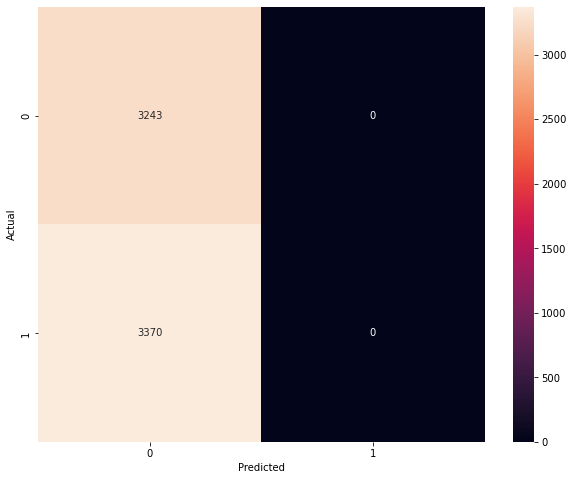

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the validation dataset
y_pred = model.predict([X_test_images, X_test])
y_pred_classes = np.argmax(y_pred, axis=1) 

# Convert to binary predictions
y_pred_binary = (y_pred_classes > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plotting
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


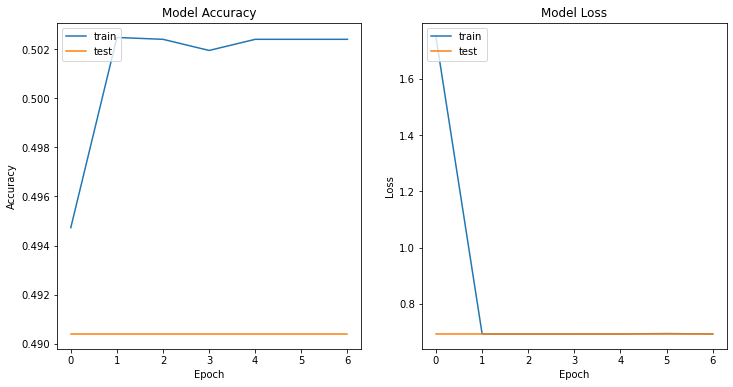

In [47]:
# Summarize history for accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


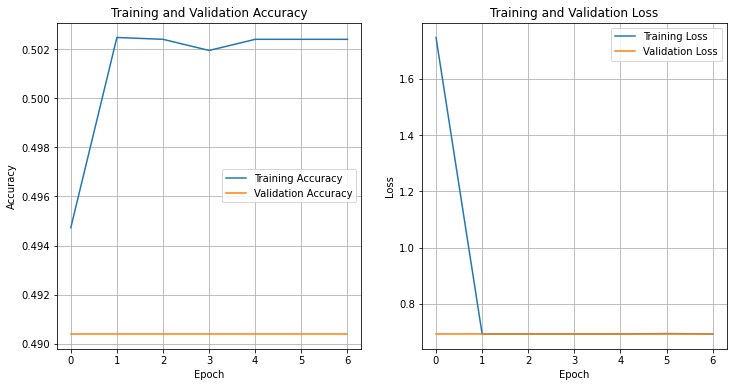

In [48]:
import matplotlib.pyplot as plt

# Set the figure size and layout
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.4)

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('learning_curve.png')

# Show the figure
plt.show()


In [34]:
# Predict using the model with both image and scalar data
y_pred_prob = model.predict([X_test_images, X_test])

# Print the first few predictions
print("Predicted probabilities for the first few samples:\n", y_pred_prob[:5])

# Convert probabilities to class labels (1 if probability > 0.5, otherwise 0)
y_pred_labels = (y_pred_prob > 0.5).astype(int)

# Print the converted class labels for the first few predictions
print("Predicted class labels for the first few samples:\n", y_pred_labels[:5])



Predicted probabilities for the first few samples:
 [[0.99963033]
 [0.9051625 ]
 [0.9051625 ]
 [0.9999833 ]
 [0.9051625 ]]
Predicted class labels for the first few samples:
 [[1]
 [1]
 [1]
 [1]
 [1]]


In [35]:
# Wrap your Keras model using the built-in sklearn wrapper for compatibility
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [36]:
def get_compiled_model():
    return model  # Use your existing model here

In [37]:
model_wrapper = KerasClassifier(build_fn=get_compiled_model, epochs=10, batch_size=10, verbose=0)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def custom_permutation_importance(model, X_images, X_scalar, y, feature_names, n_repeats=10):
    baseline_accuracy = accuracy_score(y, (model.predict([X_images, X_scalar]) > 0.5).astype(int))
    importances = np.zeros((X_scalar.shape[1], n_repeats))

    for n in range(n_repeats):
        shuffled_scores = []
        for col in range(X_scalar.shape[1]):
            X_temp = X_scalar.copy()
            X_temp[:, col] = shuffle(X_temp[:, col])
            shuffled_score = accuracy_score(y, (model.predict([X_images, X_temp]) > 0.5).astype(int))
            shuffled_scores.append(shuffled_score)
        importances[:, n] = baseline_accuracy - np.array(shuffled_scores)

    mean_importances = np.mean(importances, axis=1)
    std_importances = np.std(importances, axis=1)
    
    # Plot the feature importances
    indices = np.argsort(mean_importances)[::-1]
    plt.figure(figsize=(15, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), mean_importances[indices], color='b', yerr=std_importances[indices], align='center')
    plt.xticks(range(len(indices)), np.array(feature_names)[indices], rotation='vertical')
    plt.ylabel('Mean Decrease in Accuracy')
    plt.xlabel('Feature')
    plt.show()
    
    return mean_importances, std_importances


In [41]:
# Extract feature names from the DataFrame
feature_names = cleaned_df.drop(['target_label'], axis=1).columns.tolist()

In [ ]:

mean_importances, std_importances = custom_permutation_importance(
    model,
    X_train_images,
    X_train_scaled,
    y_train,
    feature_names,
    n_repeats=30  
)

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):  
    def __init__(self, keras_model, full_image_data):
        self.keras_model = keras_model
        self.full_image_data = full_image_data

    def predict(self, X, indices):
        # Use indices to get the corresponding subset of image data
        corresponding_image_data = self.full_image_data[indices]
        return (self.keras_model.predict([corresponding_image_data, X]) > 0.5).astype(int)

    def score(self, X, y, indices):
        y_pred = self.predict(X, indices)
        return np.mean(y_pred.ravel() == y)

In [39]:
def image_data_selector(scalar_data, full_image_data):
    indices = []
    for row in scalar_data:
        index = np.where((cleaned_df.drop(['label'], axis=1).to_numpy() == row).all(axis=1))[0]
        if len(index) > 0:
            indices.append(index[0])
    return full_image_data[indices]



In [40]:
def custom_permutation_importance(model_wrapper, X, y, indices, n_repeats=10):
    baseline_scores = []
    importances = np.zeros((X.shape[1], n_repeats))

    for _ in range(n_repeats):
        shuffled_scores = []
        for col in range(X.shape[1]):
            X_temp = X.copy()
            X_temp[:, col] = shuffle(X_temp[:, col])  # Shuffle individual column
            shuffled_scores.append(model_wrapper.score(X_temp, y, indices))

        baseline_score = model_wrapper.score(X, y, indices)
        baseline_scores.append(baseline_score)
        importances[:, _] = baseline_score - np.array(shuffled_scores)

    return np.mean(importances, axis=1), np.std(importances, axis=1)


In [41]:
# Instantiate the model wrapper
model_wrapper = KerasClassifierWrapper(model, combined_images)

In [42]:
# Calculate feature importances
mean_importances, std_importances = custom_permutation_importance(
    model_wrapper, X_test_scaled, y_test, idx_test
)

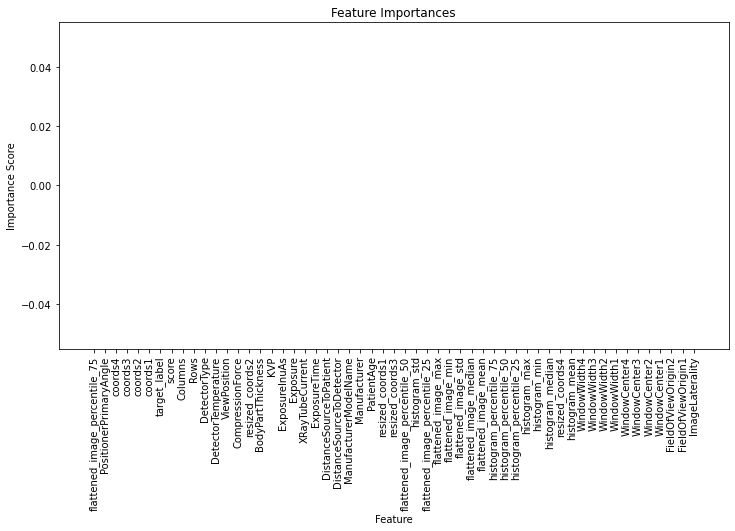

In [44]:
# Extract column names from the original DataFrame (excluding the target label)
feature_names = cleaned_df.drop(['label'], axis=1).columns

# Plot the feature importances
plt.figure(figsize=(12, 6))
indices = np.argsort(mean_importances)[::-1]
plt.title("Feature Importances")
plt.bar(range(len(mean_importances)), mean_importances[indices], color='b', align='center')
plt.xticks(range(len(mean_importances)), feature_names[indices], rotation=90)
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.show()
